In [1]:
#export
from torch.distributions.beta import Beta
from fastai2.vision.all import *

In [2]:
#export
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def begin_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def begin_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/(W*H)).type(torch.float)
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))
    
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [7]:
source = Path('./data/covid19')
train = pd.read_csv(source/'train_sm.csv')
items = get_image_files(source/'train_sm')

patient_vocab = train['PatientID'].unique()
file_vocab = train['FileID'].unique()
diagnosis_vocab = train['DiaID'].unique()

blocks = (ImageBlock(cls=PILImage), 
          CategoryBlock(vocab=diagnosis_vocab))

getters = [
           ColReader('FileID', pref=source/'train_sm/'),
           ColReader('DiaID')
]

In [8]:
xtra_tfms = [RandomResizedCrop(192)]
batch_tfms = [*aug_transforms(xtra_tfms=xtra_tfms)]

In [9]:
cov = DataBlock(blocks=blocks, 
                   getters = getters,
                   splitter=RandomSplitter(valid_pct=0.3),
                   item_tfms = Resize(224),
                   batch_tfms= batch_tfms,
                   n_inp=1
)

In [10]:
dls  = cov.dataloaders(train, bs=9, num_workers=0)

In [11]:
cutmix = CutMix(alpha=1.)

/opt/conda/conda-bld/pytorch_1587428111115/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


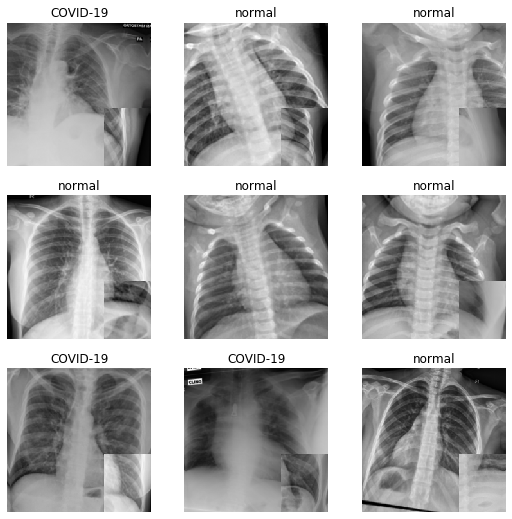

In [12]:
learn  = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), cbs=cutmix, metrics=[accuracy, error_rate])
learn._do_begin_fit(1)
learn.epoch,learn.training = 0,True
learn.dl = dls.train
b = dls.one_batch()
learn._split(b)
learn('begin_batch')
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

In [13]:
net = xresnext50(pretrained=False, sa=True, act_cls=Mish)
learn = Learner(dls, net, 
                loss_func=LabelSmoothingCrossEntropy(), 
                opt_func=ranger,
                metrics=[accuracy], 
                cbs=[ShowGraphCallback(), CollectDataCallback])

epoch,train_loss,valid_loss,accuracy,time
0,6.773796,6.783746,0.083333,00:10


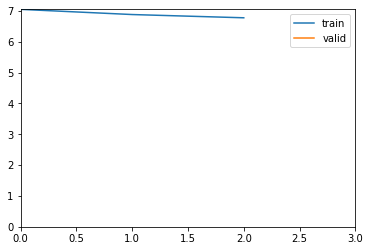

In [14]:
learn.fit_flat_cos(1, 1e-2)

In [15]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), cbs=cutmix, metrics=[accuracy, error_rate])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.516382,0.764831,0.666667,0.333333,00:04
